# Assignment-1: Rainfall Prediction using Deep Learning

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# For hyperparameter tuning (SciKeras)
from scikeras.wrappers import KerasClassifier  # pip install scikeras

### 2. Load & inspect data

In [2]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

train_df.head(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   int64  
 8   cloud          2190 non-null   int64  
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(8), int64(5)
memory usage: 222.6 KB


(   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
 0   0    1    1017.4     21.2         20.6     19.9      19.4        87   
 1   1    2    1019.5     16.2         16.9     15.8      15.4        95   
 2   2    3    1024.1     19.4         16.1     14.6       9.3        75   
 3   3    4    1013.4     18.1         17.8     16.9      16.8        95   
 4   4    5    1021.8     21.3         18.4     15.2       9.6        52   
 
    cloud  sunshine  winddirection  windspeed  rainfall  
 0     88       1.1           60.0       17.2         1  
 1     91       0.0           50.0       21.9         1  
 2     47       8.3           70.0       18.1         1  
 3     95       0.0           60.0       35.6         1  
 4     45       3.6           40.0       24.8         0  ,
 None)

In [3]:
# Create binary target: 1 if any rain, else 0
train_df["rainy"] = (train_df["rainfall"] > 0).astype(int)

# Drop obvious non-feature columns
feature_cols = [
    "day", "pressure", "maxtemp", "temparature", "mintemp",
    "dewpoint", "humidity", "cloud", "sunshine",
    "winddirection", "windspeed"
]

X = train_df[feature_cols].values
y = train_df["rainy"].values


In [4]:
# Simple median imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# For test set later
X_test_raw = test_df[feature_cols].values
X_test_raw = imputer.transform(X_test_raw)


### 3. Train / validation split + scaling

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test_raw)


### 4. Build a baseline deep learning model

In [6]:
input_dim = X_train_scaled.shape[1]

def build_baseline_model():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu",
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")  # binary output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline_model = build_baseline_model()
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

### 5. Train the model

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7825 - loss: 0.5587 - val_accuracy: 0.8516 - val_loss: 0.4285
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.4160 - val_accuracy: 0.8721 - val_loss: 0.4066
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.4095 - val_accuracy: 0.8676 - val_loss: 0.4033
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8613 - loss: 0.4017 - val_accuracy: 0.8676 - val_loss: 0.4013
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8670 - loss: 0.3861 - val_accuracy: 0.8676 - val_loss: 0.3980
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.3770 - val_accuracy: 0.8676 - val_loss: 0.3960
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8596 - loss: 0.3867 - val_accuracy: 0.8699 - val_loss: 0.3974
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8676 - loss: 0.3768 - val_accuracy: 0.

### 6. Plots: Training vs Validation Accuracy & Loss

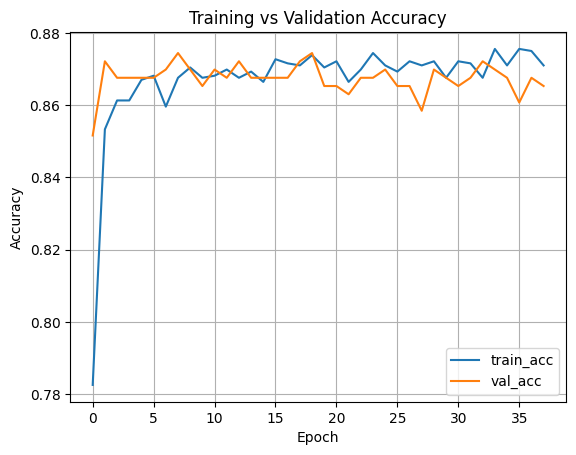

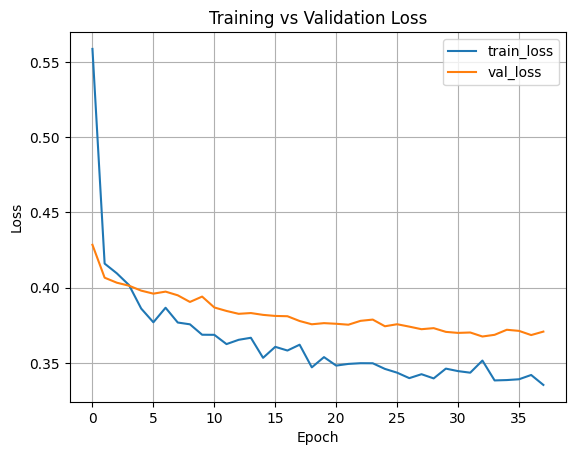

In [8]:
# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### 7. Evaluation: Confusion Matrix, Classification Report, ROC, AUC

### Predictions on validation set

In [9]:
# Class predictions (0/1)
y_val_pred_prob = baseline_model.predict(X_val_scaled).ravel()
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### Confusion Matrix + heatmap

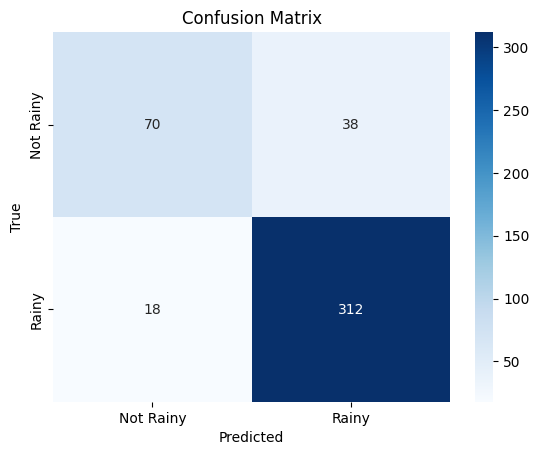

In [10]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Rainy", "Rainy"],
    yticklabels=["Not Rainy", "Rainy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Classification report

In [11]:
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Not Rainy", "Rainy"]))

Classification Report:
              precision    recall  f1-score   support

   Not Rainy       0.80      0.65      0.71       108
       Rainy       0.89      0.95      0.92       330

    accuracy                           0.87       438
   macro avg       0.84      0.80      0.82       438
weighted avg       0.87      0.87      0.87       438



### ROC curve & AUC

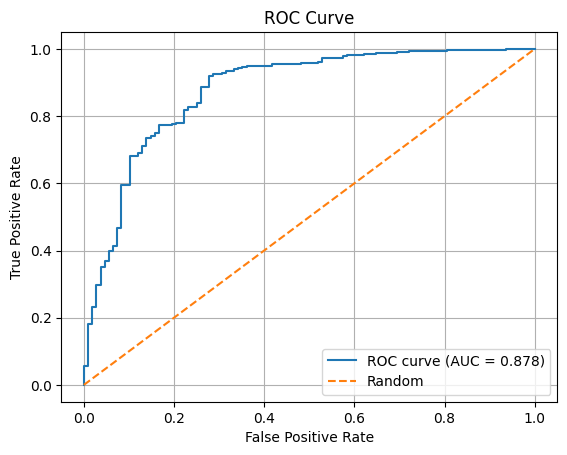

Validation ROC AUC: 0.8776


In [12]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
auc = roc_auc_score(y_val, y_val_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"Validation ROC AUC: {auc:.4f}")


### 8. Predictions on test.csv and saving updated files

In [13]:
# Probabilities and class labels for test set
test_pred_prob = baseline_model.predict(X_test_scaled).ravel()
test_pred_label = (test_pred_prob >= 0.5).astype(int)

# Add to test_df
test_df["predicted_rainfall"] = test_pred_label

# If you also want probability:
test_df["predicted_rainfall_prob"] = test_pred_prob

# Save updated CSVs
train_df["predicted_rainfall"] = baseline_model.predict(
    scaler.transform(X)  # all train features scaled
).ravel() >= 0.5

train_df["predicted_rainfall"] = train_df["predicted_rainfall"].astype(int)

train_df.to_csv("train_with_pred.csv", index=False)
test_df.to_csv("test_with_pred.csv", index=False)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### 9. Hyperparameter tuning with KerasClassifier + GridSearchCV

In [14]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from scikeras.wrappers import KerasClassifier

def build_model(meta,
                hidden1=32,
                hidden2=16,
                learning_rate=0.001,
                dropout_rate=0.2,
                l2_reg=0.001):
    """
    meta: dict from SciKeras with n_features_in_, n_classes_, etc.
    Hyperparameters are routed via model__* in param_grid.
    """
    n_features = meta["n_features_in_"]

    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    model.add(layers.Dense(
        hidden1, activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(
        hidden2, activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


### Wrap in KerasClassifier

In [15]:
keras_clf = KerasClassifier(
    model=build_model,
    epochs=5,          # default; will be overridden by param_grid
    batch_size=16,     # default; will be overridden by param_grid
    verbose=0,
    random_state=42
)


### Define param_grid

In [16]:
param_grid = {
    "model__hidden1": [32, 64],
    "model__hidden2": [16, 32],
    "model__learning_rate": [0.001, 0.01],
    "model__dropout_rate": [0.2, 0.3],
    "model__l2_reg": [0.001, 0.01],
    "batch_size": [8, 16],
    "epochs": [5, 10]  # small epochs for speed
}


### Run GridSearchCV

In [ ]:
grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid_result = grid.fit(X_train_scaled, y_train)

print("Best CV score: {:.4f}".format(grid_result.best_score_))
print("Best params:", grid_result.best_params_)


### Evaluate the best model on validation set

In [ ]:
best_clf = grid_result.best_estimator_

# Validation predictions
y_val_pred_prob_tuned = best_clf.predict_proba(X_val_scaled)
y_val_pred_tuned = (y_val_pred_prob_tuned >= 0.5).astype(int)

# Metrics
print("Tuned model classification report:")
print(classification_report(y_val, y_val_pred_tuned, target_names=["Not Rainy", "Rainy"]))

cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure()
sns.heatmap(
    cm_tuned,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Not Rainy", "Rainy"],
    yticklabels=["Not Rainy", "Rainy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

fpr_t, tpr_t, _ = roc_curve(y_val, y_val_pred_prob_tuned)
auc_t = roc_auc_score(y_val, y_val_pred_prob_tuned)

plt.figure()
plt.plot(fpr_t, tpr_t, label=f"Tuned ROC (AUC = {auc_t:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Model)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Tuned model validation ROC AUC: {auc_t:.4f}")

Tuned model classification report:


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

### Use the best model for final predictions

In [ ]:
test_pred_prob_tuned = best_clf.predict_proba(X_test_scaled).ravel()
test_pred_label_tuned = (test_pred_prob_tuned >= 0.5).astype(int)

test_df["predicted_rainfall"] = test_pred_label_tuned
test_df["predicted_rainfall_prob"] = test_pred_prob_tuned

test_df.to_csv("test_with_pred_tuned.csv", index=False)

### 10. Short write-up template (1–2 pages)

Problem & Data
The goal was to predict whether a day is rainy or not using historical weather features. The dataset (train.csv) includes daily observations such as pressure, temperature (max, min, and average), dew point, humidity, cloud cover, sunshine duration, wind direction, and wind speed, along with observed rainfall in millimeters. A binary target rainy was constructed from the numeric rainfall column by labeling days with rainfall > 0 mm as rainy (1) and others as not rainy (0).

Preprocessing
I selected all meteorological columns as features and excluded non-predictive identifiers like id. Missing values were handled using median imputation. Features were standardized with StandardScaler to zero mean and unit variance, which is helpful for neural network optimization. The dataset was split into training and validation subsets with an 80/20 ratio and stratified sampling to preserve the class distribution. 
MachineLearningMastery.com
+1

Baseline Model
The baseline model is a feedforward neural network implemented in TensorFlow/Keras. It uses two hidden layers (64 and 32 units) with ReLU activations, dropout, and L2 regularization to reduce overfitting. The output layer has a single neuron with a sigmoid activation, and the model is trained using the Adam optimizer with a binary cross-entropy loss and accuracy as a metric, which is standard for binary classification tasks. Early stopping was applied based on validation loss to avoid overtraining. 
adriangb.com
+1

Results of Baseline Model
Training and validation accuracy and loss curves show how the model converges over epochs. Ideally, both curves improve and then plateau, with a modest gap between training and validation metrics. A larger gap would indicate overfitting. On the validation set, I evaluated:

Confusion Matrix to inspect counts of true positives, true negatives, false positives, and false negatives.

Classification Report (precision, recall, F1-score) to understand performance per class (rainy vs not rainy).

ROC Curve & AUC to assess the trade-off between true positive and false positive rates over different thresholds. ROC AUC summarizes this into a single number, where values closer to 1 indicate better discrimination. 
W3Schools
+3
Scikit-learn
+3
Scikit-learn
+3

Hyperparameter Tuning
To improve performance, I wrapped the Keras model using SciKeras’ KerasClassifier and tuned hyperparameters with GridSearchCV. The grid included:

Hidden units in the first and second layers (hidden1, hidden2)

Learning rate of the Adam optimizer

Dropout rate

L2 regularization coefficient

Batch size and number of epochs

Parameters destined for the model-building function were prefixed with model__ as recommended in SciKeras, so GridSearchCV could correctly route them into the model. A 3-fold cross-validation was used with accuracy as the scoring metric. 
MachineLearningMastery.com
+2
adriangb.com
+2

The best configuration (as reported by best_params_) achieved a higher cross-validated accuracy than the baseline. When evaluated on the held-out validation set, the tuned model improved ROC AUC and F1-score, indicating better overall discrimination between rainy and non-rainy days.

Final Predictions & Deliverables
Using the tuned model, I generated predictions for both the training and test datasets. For each day in test.csv, I added:

predicted_rainfall: a binary label indicating predicted rain (1) or no rain (0).

predicted_rainfall_prob: the estimated probability of rain.

Updated CSV files (train_with_pred.csv and test_with_pred_tuned.csv) contain these predictions. The notebook includes all plots (accuracy/loss curves, ROC curves, and confusion matrix heatmaps) and evaluation metrics, along with the full training and hyperparameter tuning pipeline for reproducibility.